In [61]:
from abc import abstractmethod
from mimetypes import init
from re import I
import numpy as np
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt

class PIGP():

    def __init__(self, dim, init_data_X, init_data_Y, lower_bound, upper_bound, function_rhs, num_latent=25, num_samples=500,*args):
        self.dim = dim
        self.kr_temp = gpflow.kernels.SquaredExponential(variance=1, lengthscales=1)
        self.kr = gpflow.kernels.SquaredExponential(variance=1, lengthscales=1)
        self.gp_temp = gpflow.models.GPR(data=(init_data_X, init_data_Y), kernel=self.kr_temp)
        self.ARD(self.gp_temp)
        self.latent_X = tf.convert_to_tensor(np.linspace(lower_bound, upper_bound, num_latent)) # TODO: have a look at this all over again`
        # self.latent_X = tf.convert_to_tensor(np.random.uniform(lower_bound, upper_bound, (num_latent, dim)))
        self.samples_X = tf.convert_to_tensor(np.linspace(lower_bound, upper_bound, num_samples))
        mean, _ = self.gp_temp.predict_f(self.latent_X)
        self.latent_Y = tf.Variable(mean.numpy())
        self.function_rhs = function_rhs
        self.rhs_sample = tf.convert_to_tensor(function_rhs(self.samples_X))
        self.create_pigp(self.latent_Y)
        # self.ARD(self.pigp)  # Something fishy happens when performing ARD, check it later

    def update_pigp(self, latent_Y):
        # temp_X, temp_Y = tf.concat([self.latent_X], 0), tf.concat([latent_Y], 0)
        # self.pigp.data = (temp_X, temp_Y)
        latent_x = self.pigp.data[0]
        self.pigp.data = (latent_x, latent_Y)
    
    def create_pigp(self, latent_Y):
        # temp_X, temp_Y = tf.concat([bc_x, self.latent_X], 0), tf.concat([bc_y, latent_Y], 0)
        self.pigp = gpflow.models.GPR(data=(self.latent_X, latent_Y), kernel=self.kr)

    def pigp_hyperpaprameter_optimize(self):
        self.pigp.likelihood.variance.assign(1e-5)
        gpflow.utilities.set_trainable(self.pigp.likelihood.variance, False)
        # gpflow.utilities.set_trainable(self.pigp.data[1], True)
        opt = gpflow.optimizers.Scipy()
        # print(model.training_variables)
        opt_logs = opt.minimize(self.loss, 
                                self.pigp.trainable_variables, 
                                options=dict(maxiter=1))

    def ARD(self, model):
        model.likelihood.variance.assign(1e-5)
        gpflow.utilities.set_trainable(model.likelihood.variance, False)
        opt = gpflow.optimizers.Scipy()
        # print(model.training_variables)
        opt_logs = opt.minimize(model.training_loss, 
                                model.trainable_variables, 
                                options=dict(maxiter=100))
    
    @abstractmethod
    def loss(self):
        pass

    def train(self, num_epochs, frequency=50, train_hyperparameter=False):
        optimiser = tf.keras.optimizers.Adam()
        tf.print(f"Initial loss {self.loss()}")
        for epoch_id in range(1, num_epochs+1):
            optimiser.minimize(self.loss, self.latent_Y)
            self.pigp_hyperpaprameter_optimize()
            if epoch_id % 10 == 0:
                tf.print(f"Epoch {epoch_id}: Residual (train) {self.loss()}") 
            
    
    def plot_1d(self):
        plt.plot(self.samples_X, self.pigp.predict_f(self.samples_X)[0].numpy(), 'ko', label='PIGP')
        plt.plot(self.latent_X.numpy(), self.latent_Y.numpy(), 'r+',label='Latent points')
        plt.legend()

    def plot_initial_estimate(self):
        plt.plot(self.gp_temp.data[0].numpy(),self.gp_temp.data[1].numpy(),"ro",label="Data")
        plt.plot(self.samples_X,self.gp_temp.predict_f(self.samples_X)[0].numpy(),'k-',label="Intial GP")
        plt.plot(self.latent_X.numpy(),self.gp_temp.predict_f(self.latent_X)[0].numpy(),"g+",label="Latent GP")
        plt.legend()

class D(PIGP):

    def __init__(self, dim, init_data_X, init_data_Y, lower_bound, upper_bound, function_rhs, num_latent=20, num_samples=100, *args):
        super().__init__(dim, init_data_X, init_data_Y, lower_bound, upper_bound, function_rhs, num_latent, num_samples, *args)

    def loss(self):
        self.update_pigp(self.latent_Y)
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.samples_X)
            mean, _ = self.pigp.predict_f(self.samples_X)

        grad_mean = tape.gradient(mean, self.samples_X)
        loss_term = tf.math.reduce_mean(tf.square(self.rhs_sample - grad_mean))
        return loss_term

Initial loss 80.62783644763098
Epoch 10: Residual (train) 1.3940838535481563
Epoch 20: Residual (train) 0.5018003741901688
Epoch 30: Residual (train) 0.09943336525084476


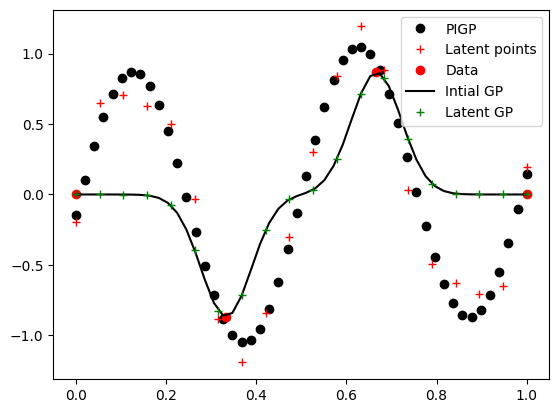

In [69]:
def target_function(X):
    return np.sin(4 * np.pi * X)

def first_derivative(X):
    return 4. * np.pi * np.cos(4 * np.pi * X)


lower, upper = [0], [1]
X = tf.convert_to_tensor(np.linspace(lower, upper, 4))
Y = tf.convert_to_tensor(target_function(X))  

# First Derivative PIGP
FD = D(1, X, Y, lower, upper, first_derivative, num_latent=20,num_samples=200)
FD.train(100)
FD.plot_1d()    
FD.plot_initial_estimate()
plt.show()

In [76]:
import tensorflow_probability as tfp

class Dvar(PIGP):

    def __init__(self, dim, init_data_X, init_data_Y, lower_bound, upper_bound, function_rhs, num_latent=20, num_samples=100, *args):
        super().__init__(dim, init_data_X, init_data_Y, lower_bound, upper_bound, function_rhs, num_latent, num_samples, *args)

    def loss(self):
        self.update_pigp(self.latent_Y)

        # Likehood like loss.
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.samples_X)
            mean, _ = self.pigp.predict_f(self.samples_X)

        grad_mean = tape.gradient(mean, self.samples_X)
        loss_term = tf.math.reduce_mean(tf.square(self.rhs_sample - grad_mean))

        # Add prior
        Kuu = self.pigp.kernel(self.latent_X,self.latent_X) + tf.convert_to_tensor(np.eye(self.latent_X.shape[0]))
        mu = tf.zeros(self.latent_Y.shape[0],dtype=np.float64)
        prior =  tfp.distributions.MultivariateNormalFullCovariance(loc=mu,covariance_matrix=Kuu)
        log_prior = prior.log_prob(tf.reshape(self.latent_Y,(self.latent_Y.shape[0],)))
        # print(loss_term,log_prior)
        l = tf.math.add(loss_term,log_prior)
        return l

Initial loss 57.854635270749114
Epoch 10: Residual (train) -25.33953005149116
Epoch 20: Residual (train) -26.1082941172722
Epoch 30: Residual (train) -26.437541975760897
Epoch 40: Residual (train) -26.78908896891393
Epoch 50: Residual (train) -28.010875682945787
Epoch 60: Residual (train) -28.178352912456333
Epoch 70: Residual (train) -28.326271330152238
Epoch 80: Residual (train) -28.479164150055425
Epoch 90: Residual (train) -28.635226187988454
Epoch 100: Residual (train) -28.795705303615566


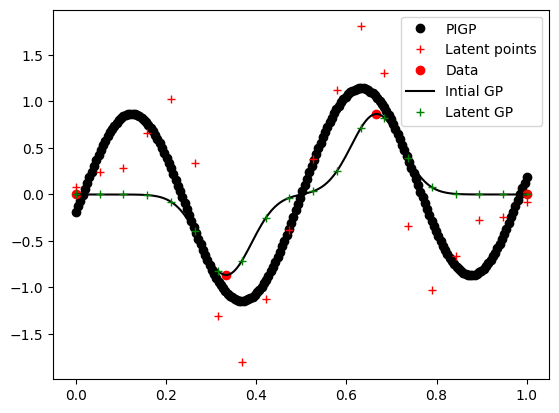

In [77]:
FD1 = Dvar(1, X, Y, lower, upper, first_derivative, num_latent=20,num_samples=200)
FD1.train(100)
FD1.plot_1d()    
FD1.plot_initial_estimate()
plt.show()